# Evaluating Model

## Extrapolation: Estimate higher wt $(>25 \%)$

Training data only input up to 25% wt% of filler. The unknown range from 25 to 50% is extrapolated in this session.

In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from   sklearn.model_selection import train_test_split
from   sklearn.preprocessing import MinMaxScaler, StandardScaler
# FUNCTIONS
from functions import *

## Import data

The data-set-8 has actual values of conductivity for wt% from $0 \%$ to $50 \%$. 

In [2]:
filename_alldata = "data-evaluation/HDPE_SWCNT_data-set-8.csv"
alldata = pd.read_csv(filename_alldata, index_col=None, header=0)
# Drop columns which are not used for now
alldata_clean = alldata.drop(['polymer_p2', 'ratio_1_2','filler_2','wt_l2','owner','foaming'], axis=1)  # , inplace=True
alldata_clean = mapStringToNum(alldata_clean)
alldata_clean.head()

,polymer_1,filler_1,wt_l1,conductivity
0,0,1,26.818297,708.533755
1,0,1,25.749656,652.784933
2,0,1,1.045467,0.714814
3,0,1,14.253655,197.505216
4,0,1,16.579815,268.298345


## Loading saved data

Loading saved model and scalers

In [3]:
model = tf.keras.models.load_model('saved/predictor-conductivity-model')

from pickle import load
X_scaler = load(open('saved/X_scaler.pkl', 'rb'))
Y_scaler = load(open('saved/Y_scaler.pkl', 'rb'))

# Extrapolation: Estimate higher wt (>25%)

In [4]:
# Easier to re-use data
unknowndata7 = alldata.copy()
unknowndata7_clean = alldata_clean.copy()

In [5]:
# Pull out columns for X (features)
X_unknowndata7 = unknowndata7_clean.drop('conductivity', axis=1).values
X_scaled_unknowndata7 = X_scaler.transform(X_unknowndata7)
# Calculate predictions
PredValSet_unknowndata7 = model.predict(X_scaled_unknowndata7)
PredValSet_unknowndata72 = Y_scaler.inverse_transform(PredValSet_unknowndata7)

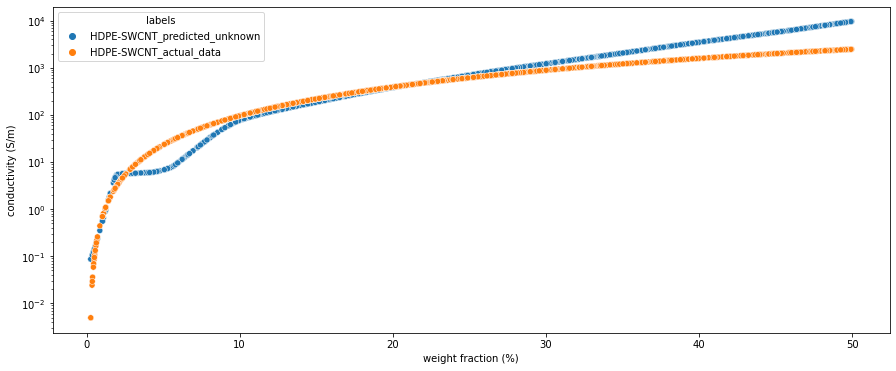

In [6]:
compdata = unknowndata7.copy()
compdata['labels']    = compdata['polymer_1'] + "-" + compdata['filler_1'] + "_predicted_unknown"
compdata['conductivity'] = PredValSet_unknowndata72

alldata['labels']    = alldata['polymer_1'] + "-" + alldata['filler_1'] + "_actual_data"
compdata_concat = pd.concat([compdata, alldata], ignore_index = True)

fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
plt.xlabel("weight fraction (%)")
plt.ylabel("conductivity (S/m)")
plt.yscale("log")
g = sns.scatterplot(data=compdata_concat ,x="wt_l1", y ="conductivity", hue="labels" , ax = ax ,markers=["-","x"] );

## Calculating Error Metrics

Let calculate the average difference in magnitude of order: for wt% from $25\%$ to $50 \%$

Mean Absolute Percentage Error = 110 %
Mean Absolute Percentage Logarithmic Error = 9 %
Root Mean Squared Error = 2802, where 1st value = 157, last value = 2443
Root Mean Squared Logarithmic Error = 0.33


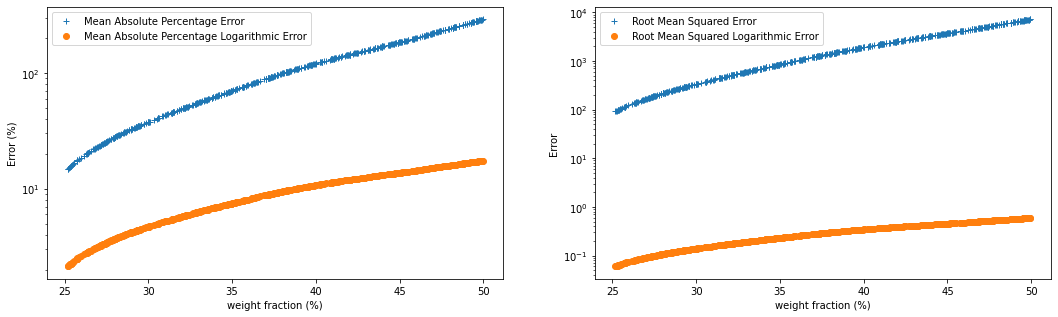

In [7]:
wt_gt25_index = alldata.wt_l1 > 25
conductivity_actual = alldata[wt_gt25_index].conductivity.copy()
conductivity_Predicted = PredValSet_unknowndata72[wt_gt25_index].flatten() # compdata.conductivity.copy()
x_range = X_unknowndata7[wt_gt25_index][:,2]

################################### First Plot: Percentage Error ################################
# Mean Absolute Percentage Error
conductivity_mape_array = 100.0 * np.abs((conductivity_actual - conductivity_Predicted)/conductivity_actual)
conductivity_mape = np.mean(conductivity_mape_array)
# Mean Absolute Percentage Logarithmic Error
conductivity_maple_array = 100.0 * np.abs(( safe_log10(conductivity_actual) - 
                                          safe_log10(conductivity_Predicted))/safe_log10(conductivity_actual) )
conductivity_maple = np.mean(conductivity_maple_array)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,5))
ax1.plot(x_range, conductivity_mape_array , label = "Mean Absolute Percentage Error", linestyle = 'None', marker="+")
ax1.plot(x_range, conductivity_maple_array ,label = "Mean Absolute Percentage Logarithmic Error", 
             linestyle = 'None', marker="o")
ax1.set(xlabel='weight fraction (%)', ylabel='Error (%)', yscale="log")
ax1.legend();
################################## Second Plot: Root Mean Squared ##################################
import math
# RMSE (Root Mean Squared Error)
conductivity_rmse_array = np.abs(np.subtract(conductivity_actual, conductivity_Predicted)) 
conductivity_rmse = math.sqrt(np.mean(np.square(conductivity_rmse_array)))
# RMSLE (Root Mean Squared Logarithmic Error)
conductivity_rmsle_array = np.abs(np.subtract(safe_log10(conductivity_actual), safe_log10(conductivity_Predicted)) )
conductivity_rmsle = math.sqrt(np.mean(np.square(conductivity_rmsle_array)))

ax2.plot(x_range, conductivity_rmse_array , label = "Root Mean Squared Error", linestyle = 'None', marker="+")
ax2.plot(x_range, conductivity_rmsle_array, label = "Root Mean Squared Logarithmic Error", 
             linestyle = 'None', marker="o")
ax2.set(xlabel='weight fraction (%)', ylabel='Error', yscale="log")
ax2.legend();
######################################## Print summary ###############################################
print("Mean Absolute Percentage Error = {0:.0f} %".format(conductivity_mape))
print("Mean Absolute Percentage Logarithmic Error = {0:.0f} %".format(conductivity_maple))
print("Root Mean Squared Error = {0:.0f}, where 1st value = {1:.0f}, last value = {2:.0f}".format(
            conductivity_rmse, conductivity_rmse_array.iloc[0],conductivity_rmse_array.iloc[-1]))
print("Root Mean Squared Logarithmic Error = {0:.2f}".format(conductivity_rmsle))

## Notice about the results and error calculation

It's clear that, without Logarithmic Conversion, the errors seem to vary highly. In cases of Root Mean Squared Error, it is thousands. Because the amount of difference depends on the magnitude and increases dramatically when it is squared.

However, in electrical conductivity for nanocomposite material field, comparing the magnitude of order is accepted as standard. Hence, it is important to let Machine Learning converge fast with suitable loss functions.

# Conclusion

## Results are acceptable
The difference between prediction and experiment is within one order of magnitude, which is acceptable.

## Issues
There are strange behaviors at a range of around 5%. 

However, our data (conductivity) of different fillers are highly divergent. The carbon nanotube has much higher intrinsic conductivity, leading CNT-based composite to have much higher electrical conductivity than the GNP one. 

Therefore, this behavior is forecasted.